In [ ]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import os,re
import folium # for visual map creation
import json
import requests
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
plt.rc('font', family='NanumBarunGothic')
mpl.rcParams['axes.unicode_minus'] = False # 마이너스 폰트
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
import glob as glob

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

# check content
!ls /content/drive/MyDrive/daegu/data

os.chdir('/content/drive/MyDrive/daegu/data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 cluster_map.png
 daegu-air-condition-20221231.csv
 daegu-subway-circulation-20230531.csv
 daegu-subway-location-20220916.csv
 daegu-subway-monthly-personnel-20230531.csv
 metro_full.csv
'대구교통공사_공조설비 현황_20230430.csv'
'대구교통공사_역사 면적_20230430.csv'
'대구교통공사_역사심도 및 높이_20161231.csv'
 좌표.csv


In [ ]:
지도 = pd.read_csv('/content/drive/MyDrive/daegu/data/metro_full.csv')
지도.head()

,호선,역명,총승객수,평균혼잡도,공기질점수,면적,정거장깊이,환기구,위도,경도
0,1,각산,0.252693,0.233176,0.137311,4976.20,13.3,3,128.724166,35.868002
1,2,감삼,0.465440,0.419939,0.940524,6136.40,21.1,4,128.547903,35.854235
2,2,경대병원,0.413771,0.428705,0.765256,10519.77,21.8,4,128.602800,35.863201
3,2,계명대,0.456792,0.412982,0.286835,10795.48,18.9,4,128.491979,35.851504
4,2,고산,0.144488,0.140142,0.080878,7819.79,21.4,3,128.693855,35.842871


In [ ]:
# folium map에 범례를 추가하는 함수 - 참조 - https://stackoverflow.com/questions/65042654/how-to-add-categorical-legend-to-python-folium-map
def add_categorical_legend(folium_map, title, colors, labels):
    if len(colors) != len(labels):
        raise ValueError("colors and labels must have the same length.")

    color_by_label = dict(zip(labels, colors))

    legend_categories = ""
    for label, color in color_by_label.items():
        legend_categories += f"<li><span style='background:{color}'></span>{label}</li>"

    legend_html = f"""
    <div id='maplegend' class='maplegend'>
      <div class='legend-title'>{title}</div>
      <div class='legend-scale'>
        <ul class='legend-labels'>
        {legend_categories}
        </ul>
      </div>
    </div>
    """
    script = f"""
        <script type="text/javascript">
        var oneTimeExecution = (function() {{
                    var executed = false;
                    return function() {{
                        if (!executed) {{
                             var checkExist = setInterval(function() {{
                                       if ((document.getElementsByClassName('leaflet-top leaflet-right').length) || (!executed)) {{
                                          document.getElementsByClassName('leaflet-top leaflet-right')[0].style.display = "flex"
                                          document.getElementsByClassName('leaflet-top leaflet-right')[0].style.flexDirection = "column"
                                          document.getElementsByClassName('leaflet-top leaflet-right')[0].innerHTML += `{legend_html}`;
                                          clearInterval(checkExist);
                                          executed = true;
                                       }}
                                    }}, 100);
                        }}
                    }};
                }})();
        oneTimeExecution()
        </script>
      """


    css = """

    <style type='text/css'>
      .maplegend {
        z-index:9999;
        float:right;
        background-color: rgba(255, 255, 255, 1);
        border-radius: 5px;
        border: 2px solid #bbb;
        padding: 10px;
        font-size:12px;
        positon: relative;
      }
      .maplegend .legend-title {
        text-align: left;
        margin-bottom: 5px;
        font-weight: bold;
        font-size: 90%;
        }
      .maplegend .legend-scale ul {
        margin: 0;
        margin-bottom: 5px;
        padding: 0;
        float: left;
        list-style: none;
        }
      .maplegend .legend-scale ul li {
        font-size: 80%;
        list-style: none;
        margin-left: 0;
        line-height: 18px;
        margin-bottom: 2px;
        }
      .maplegend ul.legend-labels li span {
        display: block;
        float: left;
        height: 16px;
        width: 30px;
        margin-right: 5px;
        margin-left: 0;
        border: 0px solid #ccc;
        }
      .maplegend .legend-source {
        font-size: 80%;
        color: #777;
        clear: both;
        }
      .maplegend a {
        color: #777;
        }
    </style>
    """

    folium_map.get_root().header.add_child(folium.Element(script + css))

    return folium_map

In [ ]:
## 지도에 공기질 / 승객수를 시각화 호선별로 확인
import branca.colormap as cm

# 대구 지도
daegu_map = folium.Map(location = [35.86320099, 128.6028004], zoom_start = 12.3, titles= 'Daegu Subway')

line_color = {1:'red', 2:'green', 3:'yellow'}
colormap = cm.LinearColormap(colors=['green', 'red'], index=[0.0,1.0],vmin=0.0,vmax=1.0)


daegu_map = add_categorical_legend(daegu_map, '호선',
                             colors = [line_color[line] for line in range(1,3)],
                           labels = [f"{line}호선" for line in range(1,3)])



for name, lat, lng, num, air, train in zip(지도.역명, 지도.경도, 지도.위도, 지도.총승객수, 지도.공기질점수, 지도.호선):
    folium.CircleMarker(
        [lat, lng],
        radius = num*40,
        color = line_color[train],
        fill=True,
        fill_color= colormap(air),
        fill_opacity=0.7,
        weight = 3,
        popup=name
    ).add_to(daegu_map)


daegu_map

In [ ]:
daegu_map.save("cluster_map.png")

In [ ]:
# K Means 클러스터링을 이용하여 역들을 군집화함

from sklearn.cluster import KMeans
np.random.seed(31415) # 실험의 재현을 위하여

air_df = 지도.loc[:, ['공기질점수', '평균혼잡도']]
distortions = []
labels = []

for k in range(1, 10):
    model = KMeans(n_clusters = k)
    labels.append(model.fit_predict(air_df))
    distortions.append(model.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

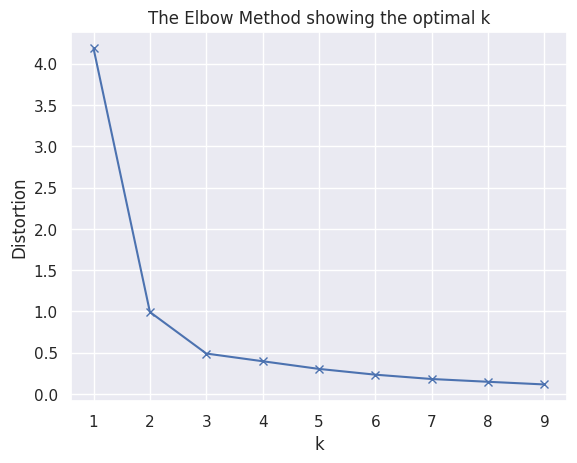

In [ ]:
# Elbow Point(3)를 군집의 개수로 사용함
plt.plot(range(1, 10), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
# 공기질점수와 환승역개수가 가장 큰 0번 군집을 사용함

지도['군집'] = labels[2]
군집별점수 = 지도.groupby('군집').mean().loc[:, ['공기질점수', '평균혼잡도']]
군집별점수.loc[3, :] = 지도.loc[:, ['공기질점수', '평균혼잡도']].mean(axis= 0)
군집별점수

<ipython-input-39-993fda95f0c9>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  군집별점수 = 지도.groupby('군집').mean().loc[:, ['공기질점수', '평균혼잡도']]


,공기질점수,평균혼잡도
군집,,
0,0.067416,0.206613
1,0.814314,0.320584
2,0.125780,0.460062
3,0.193762,0.279054


In [ ]:
## 지도에 0번 군집을 하얀색 테두리로 표시하여 나타냄
import branca.colormap as cm

# 대구 지도
daegu_map = folium.Map(location = [35.86320099, 128.6028004], zoom_start = 12.3, titles= 'Daegu Subway')

line_color = {0:'white', 1:'black', 2:'black'}
colormap = cm.LinearColormap(colors=['green', 'red'], index=[0.0,1.0],vmin=0.0,vmax=1.0)


daegu_map = add_categorical_legend(daegu_map, '후보구역',
                             colors = [line_color[line] for line in range(3)], labels = ["후보구역", "비후보구역", "비후보구역"])



for name, lat, lng, num, air, train, label in zip(지도.역명, 지도.경도, 지도.위도, 지도.총승객수, 지도.공기질점수, 지도.호선, labels[2]):
    folium.CircleMarker([lat, lng],
                        radius = num*40,
                        color = line_color[label],
                        fill=True,
                        fill_color= colormap(air),
                        fill_opacity=0.7,
                        weight = 3,
                        popup=name).add_to(daegu_map)




daegu_map

In [ ]:
from statsmodels.api import OLS

# 선정지수를 만들기 위해, 선형회귀에 모든 변수를 다 넣고 p-value를 확인함
x = 지도.loc[:, ["총승객수", "정거장깊이", "환기구", "면적"]]
y = 지도['공기질점수']

model = OLS(y, x)
fitted_model = model.fit()

fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  공기질점수   R-squared (uncentered):                   0.501
Model:                            OLS   Adj. R-squared (uncentered):              0.454
Method:                 Least Squares   F-statistic:                              10.55
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                    5.22e-06
Time:                        14:21:07   Log-Likelihood:                          1.1315
No. Observations:                  46   AIC:                                      5.737
Df Residuals:                      42   BIC:                                      13.05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
총승객수           0.6255      0.264      2.374      0.022       0.094       1.157
정거장깊이          0.0268      0.009      3.102      0.003       0.009       0.044
환기구           -0.1192      0.049     -2.416      0.020      -0.219      -0.020
면적         -7.023e-06   1.91e-05     -0.367      0.716   -4.57e-05    3.16e-05
==============================================================================
Omnibus:                       10.378   Durbin-Watson:                   1.729
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                9.835
Skew:                           1.043   Prob(JB):                      0.00732
Kurtosis:                       3.885   Cond. No.                     5.95e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 5.95e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# 면적을 빼고 다시 모델링
x = 지도.loc[:, ["총승객수", "정거장깊이", "환기구"]]
y = 지도['공기질점수']

model = OLS(y, x)
fitted_model = model.fit()

fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  공기질점수   R-squared (uncentered):                   0.500
Model:                            OLS   Adj. R-squared (uncentered):              0.465
Method:                 Least Squares   F-statistic:                              14.31
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                    1.32e-06
Time:                        13:01:15   Log-Likelihood:                          1.0579
No. Observations:                  46   AIC:                                      3.884
Df Residuals:                      43   BIC:                                      9.370
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
총승객수           0.6298      0.261      2.417      0.020       0.104       1.155
정거장깊이          0.0254      0.008      3.344      0.002       0.010       0.041
환기구           -0.1263      0.045     -2.807      0.007      -0.217      -0.036
==============================================================================
Omnibus:                       10.992   Durbin-Watson:                   1.745
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               10.619
Skew:                           1.072   Prob(JB):                      0.00494
Kurtosis:                       3.970   Cond. No.                         149.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# 각각의 지표들과 가중합을 통해 스코어를 얻고, 해당 스코어순으로 데이터프레임을 정렬함
지도['선정지수'] = fitted_model.predict(x)
지도_label0 = 지도[labels[2] == 0]
지도_sorted = 지도_label0.sort_values(by='선정지수' ,ascending=False)

In [ ]:
# 입지로 선정된 구역을 지도에 마커로 표시
import branca.colormap as cm

# 대구 지도
daegu_map = folium.Map(location = [35.86320099, 128.6028004], zoom_start = 12.3, titles= 'Daegu Subway')

line_color = {1:'red', 2:'green', 3:'yellow'}
colormap = cm.LinearColormap(colors=['blue', 'red'], index=[0.0,1.0],vmin=0.0,vmax=1.0)


daegu_map = add_categorical_legend(daegu_map, '호선',
                             colors = [line_color[line] for line in range(1,3)],
                           labels = [f"{line}호선" for line in range(1,3)])



for name, lat, lng, num, air, train, label in zip(지도.역명, 지도.경도, 지도.위도, 지도.총승객수, 지도.공기질점수, 지도.호선, labels[2]):
    folium.CircleMarker([lat, lng],
                        color = line_color[train],
                        fill=True,
                        fill_color= 'white',
                        fill_opacity=0.7,
                        weight = 3,
                        popup=name,
                        tooltip=name).add_to(daegu_map)


지도_sorted = 지도_sorted.iloc[:3 ,:]
for line, name, lat, lng, num in zip(지도_sorted.호선, 지도_sorted.역명, 지도_sorted.경도, 지도_sorted.위도, 지도_sorted.총승객수):
    folium.Marker([lat, lng]).add_to(daegu_map)



daegu_map